Implementation of LSTM Model on EUR_GBP(H1) prediction of the close price 1 hour ahead based on data of previous 24 hours

## 1. Data Preparation

### 1.1 Read in data file

In [2]:
## Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import talib as ta

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# from utils import series_to_supervised

## 2. Data Processing

In [4]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/forex/AUD_USD_H1_withindicators.csv')

In [5]:
data

,open,high,low,close,upperband,middleband,lowerband,dema,ema,ht,kama,ma,midpoint,midprice,sar,sarext,sma5,sma10,sma30,t3,tema,trima5,trima30,wma5,wma30,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cci,cmo,dx,macd,macdsignal,macdhist,macdext,macdsignalext,...,cdlgapsidesidewhite,cdlgravestonedoji,cdlhammer,cdlhangingman,cdlharami,cdlharamicross,cdlhighwave,cdlhikkake,cdlhikkakemod,cdlhomingpigeon,cdlidentical3crows,cdlinneck,cdlinvertedhammer,cdlkicking,cdlkickingbylength,cdlladderbottom,cdllongleggeddoji,cdllongline,cdlmarubozu,cdlmatchinglow,cdlmathold,cdlmorningdojistar,cdlmorningstar,cdlonneck,cdlpiercing,cdlrickshawman,cdlrisefall3methods,cdlseparatinglines,cdlshootingstar,cdlshortline,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.76660,0.76740,0.76620,0.76690,0.772125,0.767171,0.762217,0.765635,0.766812,0.766752,0.767407,0.767171,0.768300,0.767850,0.78390,-0.78390,0.767171,0.768521,0.763754,0.768484,0.769210,0.766474,0.764251,0.766168,0.766222,18.622194,20.135366,-0.001796,66.666667,20.833333,-45.833333,0.250000,-12.045280,-2.420408,8.028345,-0.000674,-0.000896,0.000222,-0.002017,-0.002322,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0
1,0.76700,0.76740,0.76680,0.76720,0.771836,0.767046,0.762255,0.765789,0.766843,0.766669,0.767403,0.767046,0.768300,0.767850,0.78390,-0.78390,0.767046,0.768473,0.763856,0.768437,0.769205,0.766215,0.764382,0.766171,0.766270,18.180784,20.082077,-0.001446,62.500000,16.666667,-45.833333,0.333333,1.665279,-0.534458,8.028345,-0.000541,-0.000825,0.000284,-0.001685,-0.002316,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0
2,0.76720,0.76720,0.76630,0.76710,0.771420,0.766892,0.762363,0.765913,0.766864,0.766620,0.767393,0.766892,0.768300,0.767850,0.78390,-0.78390,0.766892,0.768429,0.763953,0.768387,0.769195,0.766009,0.764511,0.766175,0.766315,17.888712,19.911808,-0.001083,58.333333,12.500000,-45.833333,-0.111111,-2.354326,-1.167461,11.171054,-0.000439,-0.000748,0.000309,-0.001361,-0.002224,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0
3,0.76720,0.76750,0.76620,0.76660,0.771182,0.766775,0.762368,0.765948,0.766843,0.766482,0.767375,0.766775,0.768300,0.767850,0.78390,-0.78390,0.766775,0.768383,0.764035,0.768335,0.769164,0.765858,0.764638,0.766152,0.766351,17.511787,19.774999,-0.000758,54.166667,8.333333,-45.833333,-0.461538,-1.427959,-4.343607,8.842515,-0.000391,-0.000677,0.000286,-0.001014,-0.002072,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.76660,0.76740,0.76630,0.76700,0.770581,0.766596,0.762610,0.766044,0.766855,0.766334,0.767358,0.766596,0.768300,0.767850,0.78390,-0.78390,0.766596,0.768304,0.764118,0.768282,0.769149,0.765758,0.764764,0.766170,0.766392,17.150567,19.790453,-0.000371,50.000000,4.166667,-45.833333,0.363636,11.824864,-1.617503,8.842515,-0.000319,-0.000605,0.000286,-0.000660,-0.001863,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102554,0.77218,0.77353,0.77122,0.77186,0.792204,0.781209,0.770214,0.773963,0.780610,0.786190,0.776229,0.781209,0.781010,0.781330,1.10802,-1.10802,0.781209,0.788939,0.788414,0.791109,0.787479,0.781634,0.791013,0.778297,0.789130,40.390251,32.936301,-0.004531,91.666667,0.000000,-91.666667,-0.138528,-131.966626,-43.150526,52.814038,-0.004240,-0.003783,-0.000457,-0.005248,-0.005393,...,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,-100,0,0,0,0,0,0,0,0,0
102555,0.77190,0.77235,0.77064,0.77088,0.791442,0.780397,0.769351,0.7

In [6]:
train_split_frac = 0.8
val_split_frac = 0.9

train_split = int(train_split_frac * int(data.shape[0]))  ## end of train index (exclusive)
val_split = int(val_split_frac * int(data.shape[0]))      ## end of val index (exclusive)

In [7]:
step = 1
past = 24
future = 1
learning_rate = 0.00001
batch_size = 256
epochs = 1000

y = data[['close']]

### 2.1 Train - validation - test split

In [7]:
training_data = data[: train_split]
validation_data = data[train_split: val_split]
test_data = data[val_split:]

In [8]:
print('Shape of training_data:   ', training_data.shape)
print('Shape of validation_data: ', validation_data.shape)
print('Shape of test_data:       ', test_data.shape)

Shape of training_data:    (82047, 139)
Shape of validation_data:  (10256, 139)
Shape of test_data:        (10256, 139)


### 2.2 Standardisation


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

In [10]:
training_data = scaler.fit_transform(training_data)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

### 2.3 Training dataset

In [11]:
train_y_start = past + future
train_y_end = train_y_start + train_split

In [12]:
x_train = training_data
y_train = y.iloc[train_y_start: train_y_end].values

In [13]:
sequence_length = int(past / step)

In [14]:
import tensorflow as tf
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### 2.4 Validation dataset

In [15]:
val_y_start = train_y_end
val_y_end = train_y_start + val_split

In [16]:
x_val = validation_data
y_val = y.iloc[val_y_start: val_y_end].values

In [17]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### 2.5 Test dataset

In [18]:
x_end = len(test_data) - past - future

In [19]:
test_y_start = val_y_end

In [20]:
x_test = test_data[: x_end]
y_test = y.iloc[test_y_start: ].values

In [62]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=1,
)

### 2.4 Input and output shape

In [22]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 24, 139)
Target shape: (256, 1)


## 3. Experiment1: LSTM model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import keras

### 3.1 Training

In [24]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(200)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 139)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               272000    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 272,201
Trainable params: 272,201
Non-trainable params: 0
_________________________________________________________________


In [25]:
path_checkpoint1 = "model_checkpoint_1.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=30)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint1,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model1.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/1000
321/321 [==============================] - 96s 293ms/step - loss: 0.1270 - val_loss: 0.0020

Epoch 00001: val_loss improved from inf to 0.00198, saving model to model_checkpoint_1.h5
Epoch 2/1000
321/321 [==============================] - 94s 293ms/step - loss: 0.0052 - val_loss: 0.0015

Epoch 00002: val_loss improved from 0.00198 to 0.00148, saving model to model_checkpoint_1.h5
Epoch 3/1000
321/321 [==============================] - 95s 297ms/step - loss: 0.0027 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00148 to 0.00125, saving model to model_checkpoint_1.h5
Epoch 4/1000
321/321 [==============================] - 95s 297ms/step - loss: 0.0019 - val_loss: 0.0010

Epoch 00004: val_loss improved from 0.00125 to 0.00100, saving model to model_checkpoint_1.h5
Epoch 5/1000
321/321 [==============================] - 95s 297ms/step - loss: 0.0015 - val_loss: 8.1938e-04

Epoch 00005: val_loss improved from 0.00100 to 0.00082, saving model to model_checkpoint_1.h5


### 3.2 Train and validation losses

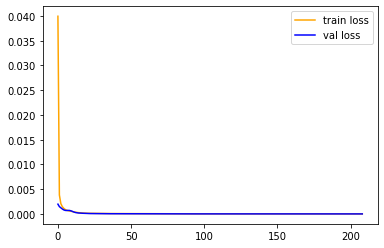

In [26]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']
plt.plot(train_loss_1, label='train loss', c='orange')
plt.plot(val_loss_1, label='val loss', c='blue')
plt.legend(loc='best')
plt.show()

### 3.3 Prediction on test dataset

In [63]:
test_prediction_1 = []
test_actual = []
for x, y in dataset_test:
    test_actual.append(y[0][0])
    predict_res = model1.predict(x)[0][0]
    test_prediction_1.append(predict_res)
test_prediction_1 = np.array(test_prediction_1)
test_actual = np.array(test_actual)


In [64]:
test_prediction_1.shape

(10208,)

In [65]:
test_data.shape

(10256, 139)

In [66]:
test_actual.shape

(10208,)

### 3.4 Evaluation

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse1 = mean_squared_error(test_actual, test_prediction_1, squared=False)
# mape1 = mean_absolute_percentage_error(test_actual, test_prediction_1)
mae1 = mean_absolute_error(test_actual, test_prediction_1)

print('result evaluation')
print('RMSE: ', rmse1)
# print('MAPE: ', mape1)
print('MAE:  ', mae1)

result evaluation
RMSE:  0.006660645549121481
MAE:   0.0058006675325833895


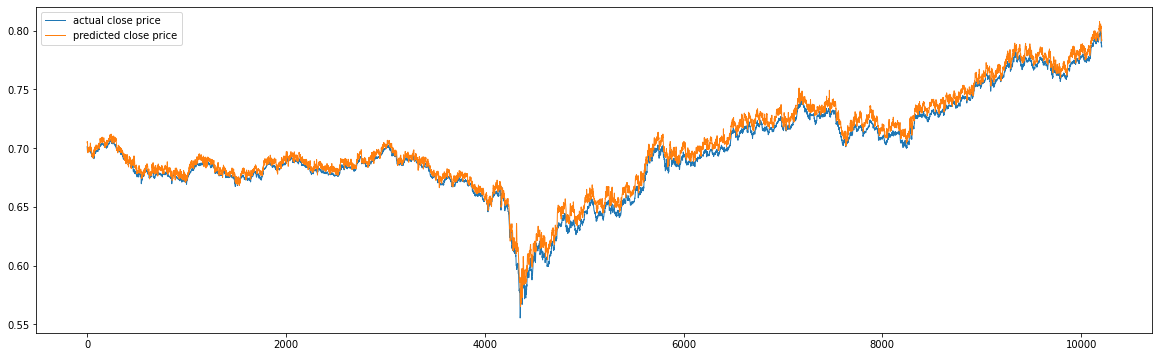

In [70]:
x_axis = [x for x in range(test_actual.shape[0])]
plt.figure(figsize=(20,6))

sns.lineplot(x=x_axis, y=test_actual, label='actual close price', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_1, label='predicted close price', linewidth=1)
plt.legend()
plt.show()

## 4. Auto-encoder and feature selection

In [8]:
data.shape

(102559, 139)

In [72]:
training_data = data[: train_split]
validation_data = data[train_split: val_split]
test_data = data[val_split:]

In [73]:
training_data = scaler.fit_transform(training_data)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

In [74]:
print('shape of training data:   ',training_data.shape)
print('shape of validation data: ',validation_data.shape)
print('shape of test data:       ',test_data.shape)

shape of training data:    (82047, 139)
shape of validation data:  (10256, 139)
shape of test data:        (10256, 139)


### 4.1 Defining the auto-encoder

In [75]:
encoding_dim = 80
ncol = training_data.shape[1]

In [76]:
from keras.layers import Input, Dense
from keras.models import Model

input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(120, activation = 'relu')(input_dim)
encoded2 = Dense(110, activation = 'relu')(encoded1)
encoded3 = Dense(100, activation = 'relu')(encoded2)
encoded4 = Dense(90, activation = 'relu')(encoded3)
encoded5 = Dense(encoding_dim, activation = 'relu')(encoded4)

# Decoder Layers
decoded1 = Dense(90, activation = 'relu')(encoded5)
decoded2 = Dense(100, activation = 'relu')(decoded1)
decoded3 = Dense(110, activation = 'relu')(decoded2)
decoded4 = Dense(120, activation = 'relu')(decoded3)
decoded5 = Dense(ncol, activation = 'relu')(decoded4)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded5)

# Compile the Model
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate*10), loss="mse")

In [77]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 139)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               16800     
_________________________________________________________________
dense_2 (Dense)              (None, 110)               13310     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               11100     
_________________________________________________________________
dense_4 (Dense)              (None, 90)                9090      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                7280      
_________________________________________________________________
dense_6 (Dense)              (None, 90)                7290

### 4.2 Training the auto-encoder

In [78]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint1,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

autoencoder.fit(
    training_data, 
    training_data, 
    epochs = 10000, 
    batch_size = 256, 
    shuffle = False, 
    validation_data = (validation_data, validation_data), 
    callbacks=[es_callback, modelckpt_callback])



Epoch 1/10000
321/321 [==============================] - 4s 11ms/step - loss: 0.1778 - val_loss: 0.1034

Epoch 00001: val_loss improved from inf to 0.10345, saving model to model_checkpoint_1.h5
Epoch 2/10000
321/321 [==============================] - 3s 10ms/step - loss: 0.1178 - val_loss: 0.0938

Epoch 00002: val_loss improved from 0.10345 to 0.09379, saving model to model_checkpoint_1.h5
Epoch 3/10000
321/321 [==============================] - 3s 10ms/step - loss: 0.1027 - val_loss: 0.0739

Epoch 00003: val_loss improved from 0.09379 to 0.07385, saving model to model_checkpoint_1.h5
Epoch 4/10000
321/321 [==============================] - 3s 11ms/step - loss: 0.0806 - val_loss: 0.0650

Epoch 00004: val_loss improved from 0.07385 to 0.06496, saving model to model_checkpoint_1.h5
Epoch 5/10000
321/321 [==============================] - 3s 10ms/step - loss: 0.0713 - val_loss: 0.0615

Epoch 00005: val_loss improved from 0.06496 to 0.06146, saving model to model_checkpoint_1.h5
Epoch 6/1

### 4.3 Dimension deduction

In [79]:
encoder = Model(inputs = input_dim, outputs = encoded5)
encoded_input = Input(shape = (encoding_dim, ))

In [80]:
encoded_train = pd.DataFrame(encoder.predict(training_data))
encoded_train = encoded_train.add_prefix('feature_')

encoded_val = pd.DataFrame(encoder.predict(validation_data))
encoded_val = encoded_val.add_prefix('feature_')

encoded_test = pd.DataFrame(encoder.predict(test_data))
encoded_test = encoded_test.add_prefix('feature_')

In [81]:
print('shape of training data:   ',encoded_train.shape)
print('shape of validation data: ',encoded_val.shape)
print('shape of test data:       ',encoded_test.shape)

shape of training data:    (82047, 80)
shape of validation data:  (10256, 80)
shape of test data:        (10256, 80)


## 5. Experiment2: LSTM model after dimension deduction

### 5.1 Data preparations

In [82]:
training_data = encoded_train.values
validation_data = encoded_val.values
test_data = encoded_test.values

In [83]:
y = data[['close']]

In [84]:
## training dataset
train_y_start = past + future
train_y_end = train_y_start + train_split

x_train = training_data
y_train = y.iloc[train_y_start: train_y_end].values

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [85]:
## validation dataset
val_y_start = train_y_end
val_y_end = train_y_start + val_split

x_val = validation_data
y_val = y.iloc[val_y_start: val_y_end].values

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [86]:
## test dataset
x_end = len(test_data) - past - future

test_y_start = val_y_end

x_test = test_data[: x_end]
y_test = y.iloc[test_y_start: ].values

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=1,
)

In [87]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 24, 80)
Target shape: (256, 1)


### 5.2 Training

In [88]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(200)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model2.summary()

## grid search

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 80)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               224800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 225,001
Trainable params: 225,001
Non-trainable params: 0
_________________________________________________________________


In [89]:
path_checkpoint2 = "model_checkpoint_2.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint2,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history2 = model2.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/1000
321/321 [==============================] - 88s 268ms/step - loss: 0.4026 - val_loss: 0.0011

Epoch 00001: val_loss improved from inf to 0.00113, saving model to model_checkpoint_2.h5
Epoch 2/1000
321/321 [==============================] - 85s 266ms/step - loss: 0.0015 - val_loss: 0.0011

Epoch 00002: val_loss improved from 0.00113 to 0.00106, saving model to model_checkpoint_2.h5
Epoch 3/1000
321/321 [==============================] - 85s 265ms/step - loss: 0.0012 - val_loss: 0.0010

Epoch 00003: val_loss improved from 0.00106 to 0.00100, saving model to model_checkpoint_2.h5
Epoch 4/1000
321/321 [==============================] - 85s 265ms/step - loss: 0.0011 - val_loss: 9.4474e-04

Epoch 00004: val_loss improved from 0.00100 to 0.00094, saving model to model_checkpoint_2.h5
Epoch 5/1000
321/321 [==============================] - 85s 266ms/step - loss: 9.0876e-04 - val_loss: 8.7087e-04

Epoch 00005: val_loss improved from 0.00094 to 0.00087, saving model to model_checkpoi

### 5.3 Train and validation losses

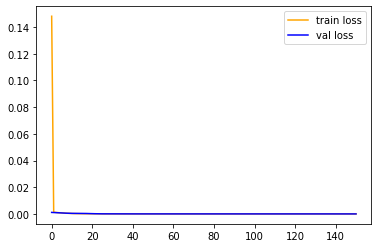

In [90]:
train_loss_2 = history2.history['loss']
val_loss_2 = history2.history['val_loss']
plt.plot(train_loss_2, label='train loss', c='orange')
plt.plot(val_loss_2, label='val loss', c='blue')
plt.legend(loc='best')
plt.show()

### 5.4 Precition on test dataset

In [91]:
test_prediction_2 = []
test_actual = []
for x, y in dataset_test:
    test_actual.append(y[0][0])
    predict_res = model2.predict(x)[0][0]
    test_prediction_2.append(predict_res)
test_prediction_2 = np.array(test_prediction_2)
test_actual = np.array(test_actual)

### 5.5 Evaluation

In [93]:
rmse2 = mean_squared_error(test_actual, test_prediction_2, squared=False)
# mape2 = mean_absolute_percentage_error(test_actual, test_prediction_2)
mae2 = mean_absolute_error(test_actual, test_prediction_2)

print('result evaluation')
print('RMSE: ', rmse2)
# print('MAPE: ', mape2)
print('MAE:  ', mae2)

result evaluation
RMSE:  0.026575507503820463
MAE:   0.02213865177037013


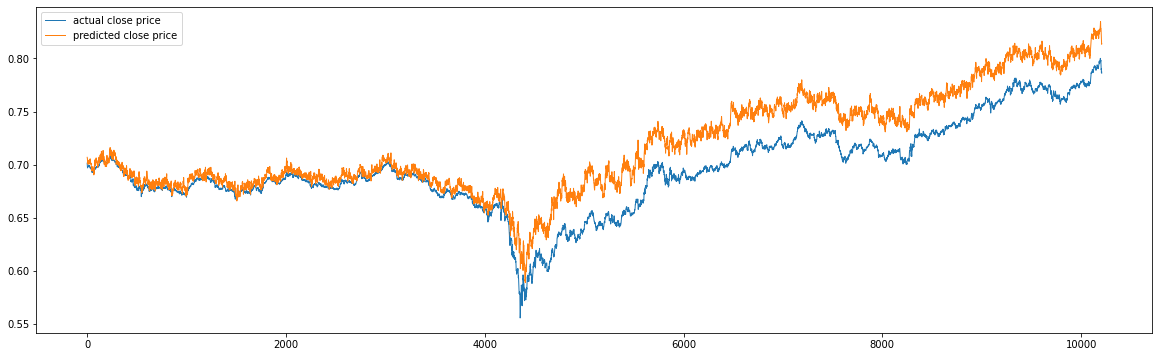

In [94]:
x_axis = [x for x in range(test_actual.shape[0])]
plt.figure(figsize=(20,6))

sns.lineplot(x=x_axis, y=test_actual, label='actual close price', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_2, label='predicted close price', linewidth=1)
plt.legend()
plt.show()

## 6. Experiment result summary

In [96]:
results = {"metrics": ['RMSE', 'MAE'], 
           "LSTM(dim=139)": [rmse1, mae1], 
           "LSTM(dim=80)": [rmse2, mae2]}
result = pd.DataFrame(results, columns=['metrics', 'LSTM(dim=139)', 'LSTM(dim=80)'])
result = result.set_index('metrics', drop=True)
result

,LSTM(dim=139),LSTM(dim=80)
metrics,,
RMSE,0.006661,0.026576
MAE,0.005801,0.022139


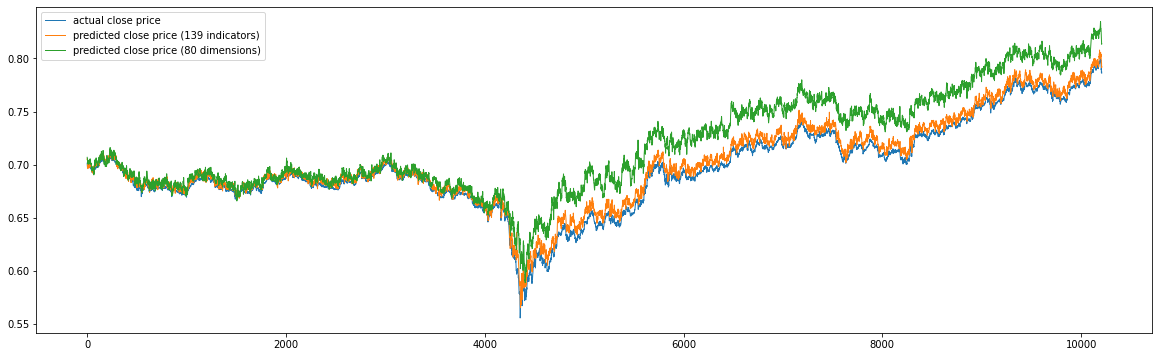

In [100]:
x_axis = [x for x in range(test_actual.shape[0])]
plt.figure(figsize=(20,6))

sns.lineplot(x=x_axis, y=test_actual, label='actual close price', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_1, label='predicted close price (139 indicators)', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_2, label='predicted close price (80 dimensions)', linewidth=1)
plt.legend(loc=2)
plt.show()

## AUD_USD_1H
## EUR_GBP_1H

## 7. LSTM auto-encoder

### 7.1 Defining the auto-encoder
tutorial: https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders

In [37]:
data.shape

(102559, 139)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [38]:
training_data = data[: train_split]
validation_data = data[train_split: val_split]
test_data = data[val_split:]

In [39]:
training_data = scaler.fit_transform(training_data)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

In [40]:
print('shape of training data:   ',training_data.shape)
print('shape of validation data: ',validation_data.shape)
print('shape of test data:       ',test_data.shape)

shape of training data:    (82047, 139)
shape of validation data:  (10256, 139)
shape of test data:        (10256, 139)


In [41]:
# reshape input into [samples, timesteps, features]
training_data = training_data.reshape((training_data.shape[0], 1, training_data.shape[1]))
validation_data = validation_data.reshape((validation_data.shape[0], 1, validation_data.shape[1]))

print('Shape of training data:   ', training_data.shape)
print('Shape of validation data: ', validation_data.shape)

Shape of training data:    (82047, 1, 139)
Shape of validation data:  (10256, 1, 139)


In [42]:
encoding_dim = 80
n_features = training_data.shape[2]
series_size = training_data.shape[1]

In [46]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model


encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(series_size, activation='relu', input_shape=(series_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(100, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(80, activation='relu'))
encoder_decoder.add(L.RepeatVector(series_size))
encoder_decoder.add(L.LSTM(series_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(100, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 1)              564       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 100)            40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 80)                57920     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 80)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 1)              328       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 100)            40800     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)             

In [48]:
adam = optimizers.Adam(learning_rate=0.0001)
encoder_decoder.compile(loss='mse', optimizer=adam)

### 7.2 Training the auto-encoder

In [52]:
from tensorflow import keras
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath='checkpoint_lstm_encoder',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

encoder_decoder.fit(
    training_data, 
    training_data, 
    epochs = 10000, 
    batch_size = 256, 
    shuffle = False, 
    validation_data = (validation_data, validation_data), 
    callbacks=[es_callback, modelckpt_callback])


Epoch 1/10000
321/321 [==============================] - 11s 19ms/step - loss: 0.2798 - val_loss: 0.2022

Epoch 00001: val_loss improved from inf to 0.20218, saving model to checkpoint_lstm_encoder
Epoch 2/10000
321/321 [==============================] - 5s 16ms/step - loss: 0.2130 - val_loss: 0.1445

Epoch 00002: val_loss improved from 0.20218 to 0.14450, saving model to checkpoint_lstm_encoder
Epoch 3/10000
321/321 [==============================] - 5s 16ms/step - loss: 0.1507 - val_loss: 0.1093

Epoch 00003: val_loss improved from 0.14450 to 0.10932, saving model to checkpoint_lstm_encoder
Epoch 4/10000
321/321 [==============================] - 5s 16ms/step - loss: 0.1139 - val_loss: 0.1001

Epoch 00004: val_loss improved from 0.10932 to 0.10009, saving model to checkpoint_lstm_encoder
Epoch 5/10000
321/321 [==============================] - 5s 16ms/step - loss: 0.1025 - val_loss: 0.1012

Epoch 00005: val_loss did not improve from 0.10009
Epoch 6/10000
321/321 [====================

### 7.3 Dimension reduction

In [56]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [57]:
training_data = encoder.predict(training_data)
validation_data = encoder.predict(validation_data)
print('Encoded training data shape:   ', training_data.shape)
print('Encoded validation data sample: ', validation_data.shape)

Encoded training data shape:    (82047, 80)
Encoded validation data sample:  (10256, 80)


In [60]:
test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

test_data = encoder.predict(test_data)
print('Encoded test data shape:   ', test_data.shape)

Encoded test data shape:    (10256, 80)


## 8. Experiment3: LSTM model after dimension reduction using LSTM encoder

### 8.1 Data preparation

In [64]:
training_data = training_data.values
validation_data = validation_data.values
test_data = test_data.values

In [65]:
y = data[['close']]

In [66]:
## training dataset
train_y_start = past + future
train_y_end = train_y_start + train_split

x_train = training_data
y_train = y.iloc[train_y_start: train_y_end].values

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [67]:
## validation dataset
val_y_start = train_y_end
val_y_end = train_y_start + val_split

x_val = validation_data
y_val = y.iloc[val_y_start: val_y_end].values

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [68]:
## test dataset
x_end = len(test_data) - past - future

test_y_start = val_y_end

x_test = test_data[: x_end]
y_test = y.iloc[test_y_start: ].values

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=1,
)

In [69]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 24, 80)
Target shape: (256, 1)


### 8.2 Training

In [79]:
learning_rate = 0.00001
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(200)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model3 = keras.Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 80)]          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 200)               224800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 225,001
Trainable params: 225,001
Non-trainable params: 0
_________________________________________________________________


In [80]:
path_checkpoint3 = "model_checkpoint_3.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=30)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint3,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history3 = model3.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/1000
321/321 [==============================] - 85s 259ms/step - loss: 0.6262 - val_loss: 0.0025

Epoch 00001: val_loss improved from inf to 0.00249, saving model to model_checkpoint_3.h5
Epoch 2/1000
321/321 [==============================] - 83s 259ms/step - loss: 0.0053 - val_loss: 0.0018

Epoch 00002: val_loss improved from 0.00249 to 0.00182, saving model to model_checkpoint_3.h5
Epoch 3/1000
321/321 [==============================] - 83s 258ms/step - loss: 0.0053 - val_loss: 0.0019

Epoch 00003: val_loss did not improve from 0.00182
Epoch 4/1000
321/321 [==============================] - 82s 257ms/step - loss: 0.0053 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00182
Epoch 5/1000
321/321 [==============================] - 83s 260ms/step - loss: 0.0052 - val_loss: 0.0020

Epoch 00005: val_loss did not improve from 0.00182
Epoch 6/1000
321/321 [==============================] - 83s 258ms/step - loss: 0.0052 - val_loss: 0.0020

Epoch 00006: val_loss did n

### 8.3 Training and validation losses

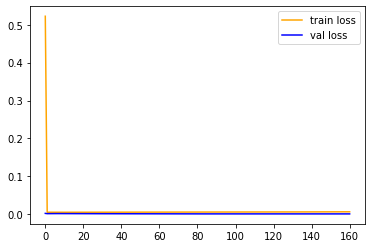

In [81]:
train_loss_3 = history3.history['loss']
val_loss_3 = history3.history['val_loss']
plt.plot(train_loss_3, label='train loss', c='orange')
plt.plot(val_loss_3, label='val loss', c='blue')
plt.legend(loc='best')
plt.show()

### 8.4 Prediction on test set

In [82]:
test_prediction_3 = []
test_actual = []
for x, y in dataset_test:
    test_actual.append(y[0][0])
    predict_res = model3.predict(x)[0][0]
    test_prediction_3.append(predict_res)
test_prediction_3 = np.array(test_prediction_3)
test_actual = np.array(test_actual)

### 8.5 Evaluation

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse3 = mean_squared_error(test_actual, test_prediction_3, squared=False)
# mape3 = mean_absolute_percentage_error(test_actual, test_prediction_3)
mae3 = mean_absolute_error(test_actual, test_prediction_3)

print('result evaluation')
print('RMSE: ', rmse3)
# print('MAPE: ', mape3)
print('MAE:  ', mae3)

result evaluation
RMSE:  0.06843910775002243
MAE:   0.05962345590122815


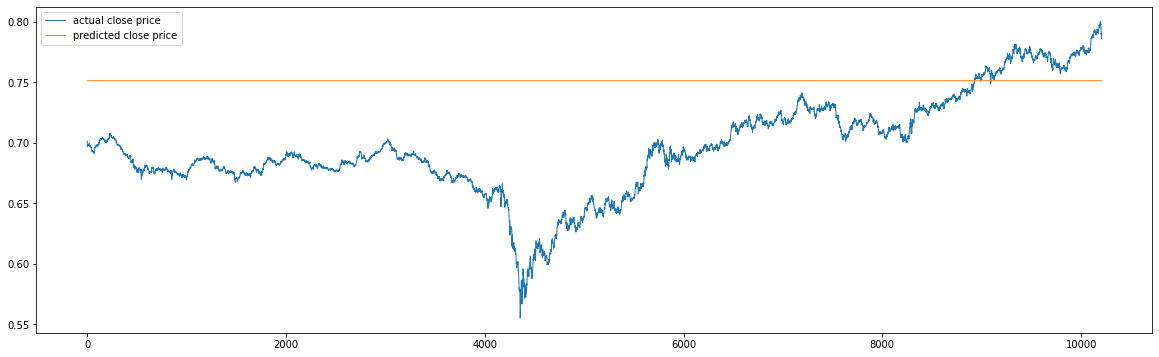

In [85]:
x_axis = [x for x in range(test_actual.shape[0])]
plt.figure(figsize=(20,6))

sns.lineplot(x=x_axis, y=test_actual, label='actual close price', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_3, label='predicted close price', linewidth=1)
plt.legend()
plt.show()